# 特徴量の選択

## ライブラリーのインポート

In [11]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

## データセットの生成

In [12]:
# データセットをロード
dataset = datasets.load_breast_cancer()
# 一意なクラスラベルを出力
print('特徴量:', dataset.feature_names)
print('クラス:', np.unique(dataset.target))

特徴量: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
クラス: [0 1]


## データセットの確認

In [13]:
pd.set_option('display.max_columns', None)
# データセットの特徴量をDataFrameに変換
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)

# 目標変数をDataFrameに追加
df['target'] = dataset.target
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## 説明変数と目的変数に分割

In [14]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

## 訓練データとテストデータに分割

In [15]:
# 全体の30%をテストデータととする
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y)

## 特徴量スケーリング

In [16]:
# 標準化のスケーリングのインスタンスの生成
scaler = StandardScaler()
# 訓練データをスケーリング
X_train_std = scaler.fit_transform(X_train)
# テストデータをスケーリング
X_test_std = scaler.transform(X_test)

## 逐次(ちくじ)後退選択(SBS)

In [17]:
from itertools import combinations
from sklearn.base import clone
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [18]:
class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring #特徴量を評価する指標
        self.estimator = clone(estimator) #推定器
        self.k_features = k_features #選択する特徴量の個数
        self.test_size = test_size #テストデータの割合
        self.random_state = random_state #乱数シードを固定

    def fit(self, X, y):
        #訓練データとテストデータを分割
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)
        #全ての特徴量の個数、列インデックス
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        #全ての特徴量を用いてスコアを算出
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score] #スコアを格納
        #特徴量が指定した個数になるまで処理を繰り返す
        while dim > self.k_features:
            scores = [] #空のスコアリストを作成
            subsets = [] #空の列インデックスリストを作成
            #特徴量の部分集合を表す列インデックスの組み合わせごとに処理を反復
            for p in combinations(self.indices_, r=dim - 1):
                #スコアを算出して格納
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                #特徴量の部分集合を表す列インデックスのリストを格納
                subsets.append(p)
            #最良のスコアのインデックスを抽出
            best = np.argmax(scores)
            #最良のスコアとなる列インデックスを抽出して格納
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            #特徴量の個数を1つだけ減らして次のステップへ
            dim -= 1
            #スコアを格納
            self.scores_.append(scores[best])
        #最後に格納したスコア
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        #抽出した特徴量を返す
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        #指定された列番号indicesの特徴量を抽出してモデルを適合
        self.estimator.fit(X_train[:, indices], y_train)
        #テストデータを用いてクラスラベルを予測
        y_pred = self.estimator.predict(X_test[:, indices])
        #真のクラスラベルと予測値を用いてスコアを算出
        score = self.scoring(y_test, y_pred)
        return score

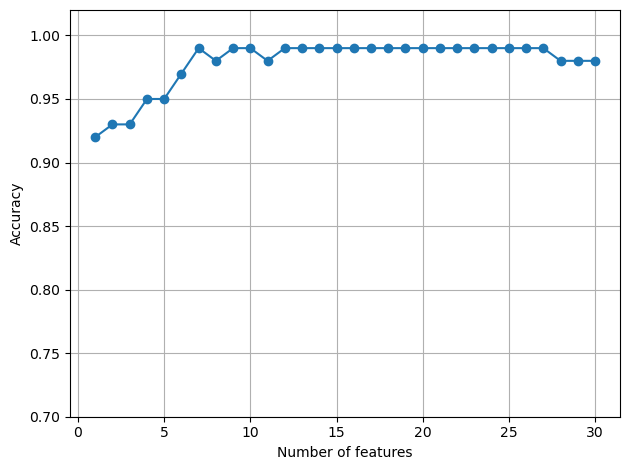

In [19]:
# kNNのインスタンスを生成
classifier = KNeighborsClassifier(n_neighbors=5)

# SBSのインスタンスを生成(特徴量の個数が一個になるまで特徴量を選択)
sbs = SBS(classifier, k_features=1)
# SBSを実行
sbs.fit(X_train_std, y_train)

# 特徴量の個数のリスト
k_feat = [len(k) for k in sbs.subsets_]

# 横軸を特徴量の個数、縦軸をスコアとしたとした折れ線グラフをプロット
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
plt.show()

In [22]:
k3 = list(sbs.subsets_[23])#(元の特徴量の数(30) - 23 = 7)
print(df.columns[1:][k3])

Index(['mean texture', 'mean area', 'mean smoothness',
       'mean fractal dimension', 'texture error', 'compactness error',
       'worst radius'],
      dtype='object')


In [24]:
# 13個全ての特徴量を用いてモデルを適合
classifier.fit(X_train_std, y_train)
print('Training accuracy:', classifier.score(X_train_std, y_train))
print('Test accuracy:', classifier.score(X_test_std, y_test))

Training accuracy: 0.9798994974874372
Test accuracy: 0.9473684210526315


In [25]:
# 7個の特徴量を用いてモデルを適合
classifier.fit(X_train_std[:, k3], y_train)
print('Training accuracy:', classifier.score(X_train_std[:, k3], y_train))
print('Test accuracy:', classifier.score(X_test_std[:, k3], y_test))

Training accuracy: 0.9547738693467337
Test accuracy: 0.8830409356725146


## 特徴量の重要度を評価

In [26]:
from sklearn.ensemble import RandomForestClassifier

 1) worst area                     0.147933
 2) worst symmetry                 0.127659
 3) worst texture                  0.117094
 4) worst smoothness               0.107753
 5) mean symmetry                  0.099719
 6) mean concave points            0.061538
 7) mean area                      0.046928
 8) mean texture                   0.043716
 9) mean smoothness                0.041994
10) worst concave points           0.035739
11) smoothness error               0.029460
12) area error                     0.014739
13) worst concavity                0.013120
14) mean perimeter                 0.012069
15) worst perimeter                0.012057
16) texture error                  0.011405
17) mean concavity                 0.011200
18) worst compactness              0.010849
19) worst fractal dimension        0.008620
20) concave points error           0.006117
21) target                         0.005528
22) mean compactness               0.005019
23) perimeter error             

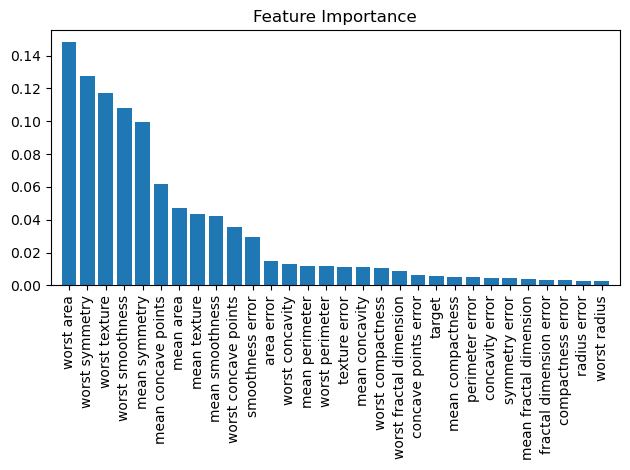

In [27]:
# データセットの特徴量の選択
feat_labels = df.columns[1:]
# ランダムフォレストオブジェクトの生成(決定木の個数=500)
forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)
# モデルの適合
forest.fit(X_train, y_train)
# 特徴量の重要度抽出
importances = forest.feature_importances_
# 重要度の降順で特徴量のインデックスを抽出
indices = np.argsort(importances)[::-1]
# 重要度の降順で特徴量の名称、重要度を表示
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))


plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('images/04_09.png', dpi=300)
plt.show()

Number of features that meet this threshold criterion: 4
 1) worst area                     0.147933
 2) worst symmetry                 0.127659
 3) worst texture                  0.117094
 4) worst smoothness               0.107753


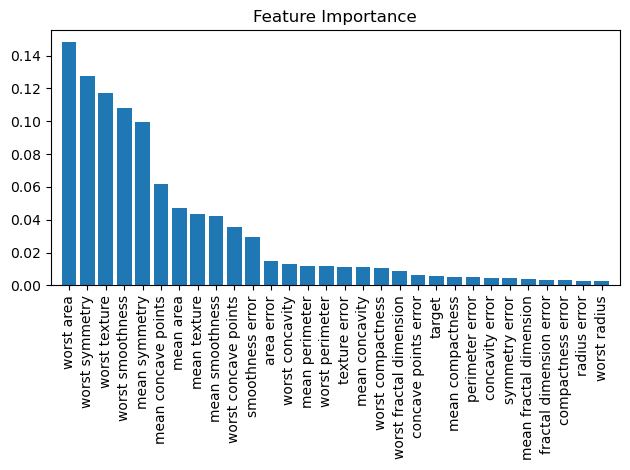

In [28]:

from sklearn.feature_selection import SelectFromModel

# データセットの特徴量の選択
feat_labels = df.columns[1:]
# ランダムフォレストオブジェクトの生成(決定木の個数=500)
forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)
# モデルの適合
forest.fit(X_train, y_train)
# 特徴量の重要度抽出
importances = forest.feature_importances_
# 重要度の降順で特徴量のインデックスを抽出
indices = np.argsort(importances)[::-1]

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('Number of features that meet this threshold criterion:', 
      X_selected.shape[1])
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('images/04_09.png', dpi=300)
plt.show()